In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
ls /kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks

a.us.txt          dhil.us.txt       jmlp.us.txt       qtwo.us.txt
aa.us.txt         dhr.us.txt        jmm.us.txt        quad.us.txt
aaap.us.txt       dht.us.txt        jmom.us.txt       quik.us.txt
aaba.us.txt       dhvw.us.txt       jmp.us.txt        qumu.us.txt
aac.us.txt        dhx.us.txt        jmpb.us.txt       quot.us.txt
aal.us.txt        dhxm.us.txt       jmpc.us.txt       qure.us.txt
aamc.us.txt       dhy.us.txt        jmt.us.txt        qval.us.txt
aame.us.txt       dial.us.txt       jmu.us.txt        qvca.us.txt
aan.us.txt        diax.us.txt       jnce.us.txt       qvcb.us.txt
aaoi.us.txt       din.us.txt        jnj.us.txt        qvm.us.txt
aaon.us.txt       diod.us.txt       jnp.us.txt        qxgg.us.txt
aap.us.txt        dis.us.txt        jnpr.us.txt       qxmi.us.txt
aapl.us.txt       disca.us.txt      job.us.txt        qxrr.us.txt
aat.us.txt        discb.us.txt      jobs.us.txt       qxtr.us.txt
aau.us.txt        disck.us.txt      joe.us.txt        r.us.txt
aav.us.txt    

In [ ]:
import os
import sys
import math
import random
import warnings

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense , BatchNormalization , Dropout , Activation
from tensorflow.keras.layers import LSTM , GRU
from tensorflow.keras.optimizers import Adam , SGD , RMSprop
from tensorflow.keras.callbacks import ReduceLROnPlateau , ModelCheckpoint
from tensorflow.keras.models import load_model

warnings.filterwarnings('ignore')

pd.options.display.max_columns = 1000
pd.options.display.max_rows = 10000
pd.options.display.max_colwidth = -1

def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

RANDOM_STATE = 313
seed_everything(seed=RANDOM_STATE)

In [ ]:
data = pd.read_csv('/kaggle/input/price-volume-data-for-all-us-stocks-etfs/Stocks/diod.us.txt')

In [ ]:
data.isna().sum()

Date       0
Open       0
High       0
Low        0
Close      0
Volume     0
OpenInt    0
dtype: int64

In [ ]:
len(data)

3201

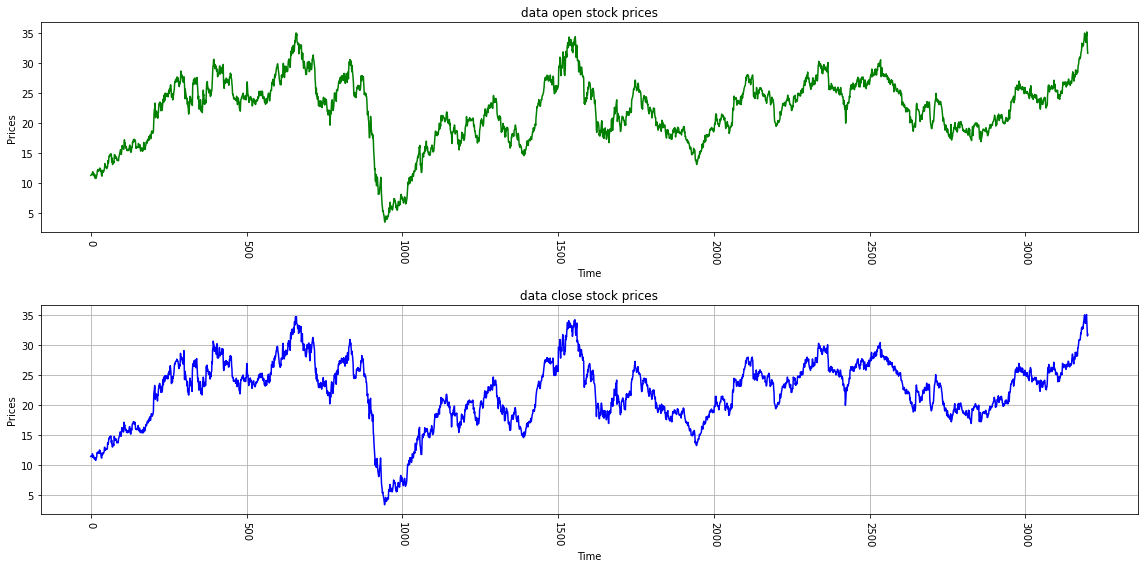

correlation: 0.9959


In [ ]:
def plotter(df):
    # company = df[df['symbol'] == symbol]
    open_values = df.Open.values.astype('float32').reshape(-1, 1)
    close_values = df.Close.values.astype('float32').reshape(-1, 1)
    
    fig, axes = plt.subplots(2, 1, figsize=(16, 8))
    axes[0].set_xlabel('Time')
    axes[0].set_ylabel('Prices')
    axes[0].set_title('data open stock prices')
    axes[0].plot(open_values , 'g')
    axes[0].xaxis.set_tick_params(rotation=270)
    

    axes[1].set_xlabel('Time')
    axes[1].set_ylabel('Prices')
    axes[1].set_title('data close stock prices')
    axes[1].plot(close_values , 'b')
    axes[1].xaxis.set_tick_params(rotation=270)
    
    fig.tight_layout()
    plt.grid(True)
    plt.show()
# 
# symbol = 'YHOO'
plotter(data)

# symbol_df = data.loc[data['symbol'] == symbol]
print(f"correlation: {np.around(data[['Open', 'Close']].corr().values[0, 1], 4)}")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3201 entries, 0 to 3200
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Date     3201 non-null   object 
 1   Open     3201 non-null   float64
 2   High     3201 non-null   float64
 3   Low      3201 non-null   float64
 4   Close    3201 non-null   float64
 5   Volume   3201 non-null   int64  
 6   OpenInt  3201 non-null   int64  
dtypes: float64(4), int64(2), object(1)
memory usage: 175.2+ KB


In [ ]:
data['Date'] = pd.to_datetime(data['Date'])

In [ ]:
series = data[['Close']]
series_mean = series.mean().values.item()
series = series - series_mean
scaler = MinMaxScaler(feature_range=(0, 1))
series = scaler.fit_transform(series)

In [ ]:
pd.DataFrame(series).describe()

,0
count,3201.000000
mean,0.592875
std,0.173096
min,0.000000
25%,0.487204
50%,0.622749
75%,0.715324
max,1.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb066f59a10>]],
      dtype=object)

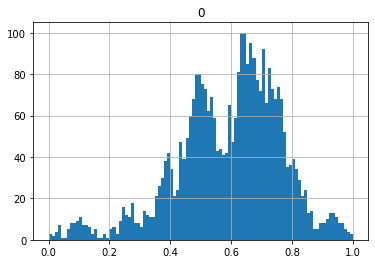

In [ ]:
pd.DataFrame(series).hist(bins=100)

In [ ]:
train_length = int(len(series) * 0.8)
train = series[:train_length]
test = series[train_length:]
train.shape, test.shape

((2560, 1), (641, 1))

In [ ]:
def process_data(data, n_steps):
    X, y = list(), list()
    for i in range(len(data) - n_steps):
        sequence = data[i : (i + n_steps), 0]
        X.append(sequence)
        y.append(data[i + n_steps, 0])
    return np.array(X), np.array(y)

In [ ]:
n_steps = 2
X_train, y_train = process_data(train, n_steps)
X_test, y_test = process_data(test, n_steps)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2558, 2) (2558,) (639, 2) (639,)


In [ ]:
X_train = np.expand_dims(X_train, -1)
X_test = np.expand_dims(X_test, -1)

print(X_train.shape, X_test.shape)

(2558, 2, 1) (639, 2, 1)


In [ ]:
filepath = './model.h5'
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.8, min_delta=0.0001, patience=10, verbose=1)
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [ ]:
model = Sequential()
model.add(GRU(128 , input_shape=(n_steps, 1) , return_sequences=True))
model.add(Dropout(0.25))
model.add(LSTM(256))
model.add(Dropout(0.25))
model.add(Dense(64 ,  activation = 'relu'))
model.add(Dense(16 ,  activation = 'relu'))
model.add(Dense(1))
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, 2, 128)            50304     
_________________________________________________________________
dropout (Dropout)            (None, 2, 128)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 256)               394240    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense (Dense)                (None, 64)                16448     
_________________________________________________________________
dense_1 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 1

In [ ]:
model.compile(loss='mean_squared_error', optimizer=RMSprop(lr = 0.0001) , metrics = ['mean_squared_error'])

In [ ]:
history = model.fit(X_train, 
                    y_train, 
                    epochs=50, 
                    batch_size=256, 
                    callbacks=[checkpoint, lr_reduce], 
                    validation_data=(X_test, y_test))

Epoch 1/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.3643 - mean_squared_error: 0.3643
Epoch 00001: val_loss improved from inf to 0.35364, saving model to ./model.h5
10/10 [==============================] - 1s 93ms/step - loss: 0.3631 - mean_squared_error: 0.3631 - val_loss: 0.3536 - val_mean_squared_error: 0.3536
Epoch 2/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.3225 - mean_squared_error: 0.3225
Epoch 00002: val_loss improved from 0.35364 to 0.30936, saving model to ./model.h5
10/10 [==============================] - 0s 39ms/step - loss: 0.3195 - mean_squared_error: 0.3195 - val_loss: 0.3094 - val_mean_squared_error: 0.3094
Epoch 3/50
 9/10 [==========================>...] - ETA: 0s - loss: 0.2793 - mean_squared_error: 0.2793
Epoch 00003: val_loss improved from 0.30936 to 0.26108, saving model to ./model.h5
10/10 [==============================] - 0s 45ms/step - loss: 0.2766 - mean_squared_error: 0.2766 - val_loss: 0.2611 - val_mean_squared_error: 

 9/10 [==========================>...] - ETA: 0s - loss: 0.0017 - mean_squared_error: 0.0017
Epoch 00050: val_loss did not improve from 0.00034

Epoch 00050: ReduceLROnPlateau reducing learning rate to 5.119999987073243e-05.
10/10 [==============================] - 0s 37ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - val_loss: 3.3951e-04 - val_mean_squared_error: 3.3951e-04


In [ ]:
3.3951e-04

0.00033951

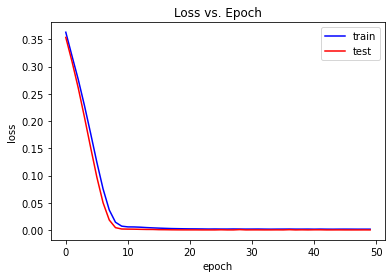

In [ ]:
plt.plot(history.history['loss'], color='b', label='train')
plt.plot(history.history['val_loss'], color='r', label='test')
plt.title('Loss vs. Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(loc='upper right')
plt.show()

In [ ]:
def model_score(model, X_train, y_train, X_test, y_test):
    train_score = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (train_score[0], math.sqrt(train_score[0])))
    test_score = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (test_score[0], math.sqrt(test_score[0])))

model_score(model, X_train, y_train , X_test, y_test)

Train Score: 0.00056 MSE (0.02 RMSE)
Test Score: 0.00034 MSE (0.02 RMSE)


In [ ]:
pred = model.predict(X_test)
pred = scaler.inverse_transform(pred) + series_mean

In [ ]:
y_test = y_test[..., np.newaxis]
y_test = scaler.inverse_transform(y_test) + series_mean

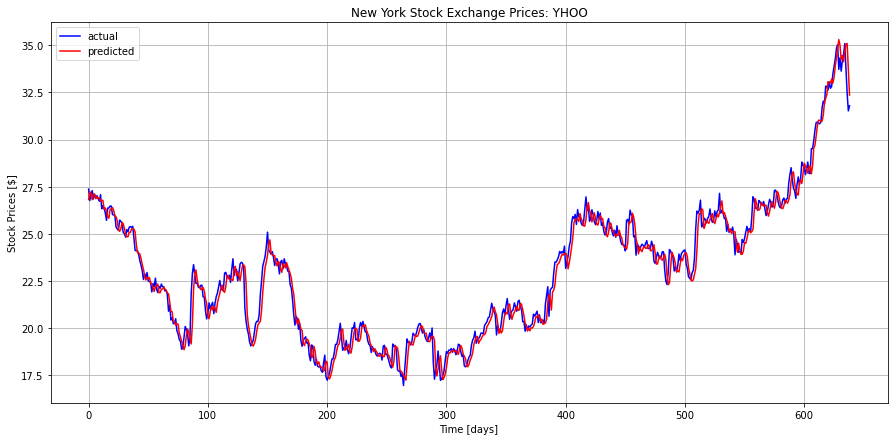

In [ ]:
plt.rcParams["figure.figsize"] = (15,7)
plt.plot(y_test, label='actual', color='b')
plt.plot(pred, label='predicted', color='r')
plt.xlabel('Time [days]')
plt.ylabel('Stock Prices [$]')
# plt.title('New York Stock Exchange Prices: DIOD')
plt.legend(loc='upper left')
plt.grid(True)
plt.show()

In [ ]:
####

In [ ]:
import pandas as pd
import numpy as np
import keras
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
df = data.copy()

In [ ]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_axis(df['Date'], inplace=True)
df.drop(columns=['Open', 'High', 'Low', 'Volume'], inplace=True)

In [ ]:
df

,Date,Close,OpenInt
Date,,,
2005-02-25,2005-02-25,11.4700,0
2005-02-28,2005-02-28,11.4300,0
2005-03-01,2005-03-01,11.5700,0
2005-03-02,2005-03-02,11.6000,0
2005-03-03,2005-03-03,11.5600,0
2005-03-04,2005-03-04,11.9200,0
2005-03-07,2005-03-07,11.8800,0
2005-03-08,2005-03-08,11.3000,0
2005-03-09,2005-03-09,11.6000,0


In [ ]:
close_data = df['Close'].values
close_data = close_data.reshape((-1,1))

split_percent = 0.80
split = int(split_percent*len(close_data))

close_train = close_data[:split]
close_test = close_data[split:]

date_train = df['Date'][:split]
date_test = df['Date'][split:]

print(len(close_train))
print(len(close_test))

2560
641


In [ ]:
look_back = 15

train_generator = TimeseriesGenerator(close_train, close_train, length=look_back, batch_size=20)     
test_generator = TimeseriesGenerator(close_test, close_test, length=look_back, batch_size=1)

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, Dense

model = Sequential()
model.add(
    LSTM(10,
        activation='relu',
        input_shape=(look_back,1))
)
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

num_epochs = 25
model.fit_generator(train_generator, epochs=num_epochs, verbose=1)

Epoch 1/25
128/128 [==============================] - 1s 6ms/step - loss: 6.2622
Epoch 2/25
128/128 [==============================] - 1s 6ms/step - loss: 2.6386
Epoch 3/25
128/128 [==============================] - 1s 6ms/step - loss: 2.5774
Epoch 4/25
128/128 [==============================] - 1s 6ms/step - loss: 2.5999
Epoch 5/25
128/128 [==============================] - 1s 6ms/step - loss: 2.5670
Epoch 6/25
128/128 [==============================] - 1s 6ms/step - loss: 2.2283
Epoch 7/25
128/128 [==============================] - 1s 6ms/step - loss: 1.3802
Epoch 8/25
128/128 [==============================] - 1s 5ms/step - loss: 1.0590
Epoch 9/25
128/128 [==============================] - 1s 5ms/step - loss: 0.8640
Epoch 10/25
128/128 [==============================] - 1s 6ms/step - loss: 0.8100
Epoch 11/25
128/128 [==============================] - 1s 6ms/step - loss: 0.7688
Epoch 12/25
128/128 [==============================] - 1s 6ms/step - loss: 0.7182
Epoch 13/25
128/128 [====

In [ ]:
import plotly.graph_objects as go

In [ ]:
prediction = model.predict_generator(test_generator)

close_train = close_train.reshape((-1))
close_test = close_test.reshape((-1))
prediction = prediction.reshape((-1))

trace1 = go.Scatter(
    x = date_train,
    y = close_train,
    mode = 'lines',
    name = 'Data'
)
trace2 = go.Scatter(
    x = date_test,
    y = prediction,
    mode = 'lines',
    name = 'Prediction'
)
trace3 = go.Scatter(
    x = date_test,
    y = close_test,
    mode='lines',
    name = 'Ground Truth'
)
layout = go.Layout(
    title = "Diodes Stock",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"}
)
fig = go.Figure(data=[trace1, trace2, trace3], layout=layout)
fig.show()

In [ ]:
close_data = close_data.reshape((-1))

def predict(num_prediction, model):
    prediction_list = close_data[-look_back:]
    
    for _ in range(num_prediction):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
    prediction_list = prediction_list[look_back-1:]
        
    return prediction_list
    
def predict_dates(num_prediction):
    last_date = df['Date'].values[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+1).tolist()
    return prediction_dates

num_prediction = 30
forecast = predict(num_prediction, model)
forecast_dates = predict_dates(num_prediction)